In [1]:
# Load libraries

# # Plotting utils 
import matplotlib.pyplot as plt 
import matplotlib.colors as colors
import matplotlib.ticker as ticker 
import matplotlib.patches as patches
import matplotlib as matplotlib
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Analysis
import os
import numpy as np 
import xarray as xr
import datetime
from   datetime import date, timedelta
import pandas as pd 
#import regionmask
import pickle
import scipy.stats as stats
import glob
import Ngl
import Nio 


In [2]:
import warnings
warnings.filterwarnings('ignore')


## Read in data from SCAM runs (32 levs and 64 levels)

In [3]:
# Where the files are saved (locally):
dataDir32 = '/Users/mdfowler/Documents/Analysis/CLASP/SCAM_runs/AllMomentsSet/'
dataDir64 = '/Users/mdfowler/Documents/Analysis/CLASP/SCAM_runs/AllMoments-64levs/'
dirNoMom  = '/Users/mdfowler/Documents/Analysis/CLASP/SCAM_runs/HMG_noMomentsPrescribed/'  # 32 levels

# File naming conventions: 
hmg_startFile   = 'FSCAM.T42_T42.arm97.clasp_hmg_startDay'   # 32 and 64 level files *start* the same way
htg_startFile   = 'FSCAM.T42_T42.arm97.clasp_htg_startDay'
noMom_startFile = 'FSCAM.T42_T42.arm97.clasp_hmg_noMoments_startDay'
middleFile32    = '_allMoments.cam.h0.2015-' # Default 20 min coupling
middleFile64    = '_64lev_AllMoments.cam.h0.2015-' # Default 20 min coupling
noMom_middle    = '.cam.h0.2015-'
endFile         = '-00000.nc'

# Month/day also factor into naming convention (since these are run for ~2 days and second day is used)
months    = np.ones(31)*6
months[0] = 5
days      = np.arange(0,31)
days[0]   = 31


In [4]:
# Now read in each daily file, and save the appropriate second day to an xr dataset: 

for iDay in range(30):
    
    # Define full file names 
    hmg32file    = dataDir32+hmg_startFile+'0'+str(months[iDay].astype(int))+str('%02i' % days[iDay])+middleFile32+'0'+str(months[iDay].astype(int))+'-'+str('%02i' % days[iDay])+endFile
    htg32file    = dataDir32+htg_startFile+'0'+str(months[iDay].astype(int))+str('%02i' % days[iDay])+middleFile32+'0'+str(months[iDay].astype(int))+'-'+str('%02i' % days[iDay])+endFile
    hmg64file    = dataDir64+hmg_startFile+'0'+str(months[iDay].astype(int))+str('%02i' % days[iDay])+middleFile64+'0'+str(months[iDay].astype(int))+'-'+str('%02i' % days[iDay])+endFile
    htg64file    = dataDir64+htg_startFile+'0'+str(months[iDay].astype(int))+str('%02i' % days[iDay])+middleFile64+'0'+str(months[iDay].astype(int))+'-'+str('%02i' % days[iDay])+endFile
    noMomFile    = dirNoMom+noMom_startFile+'0'+str(months[iDay].astype(int))+str('%02i' % days[iDay])+noMom_middle+'0'+str(months[iDay].astype(int))+'-'+str('%02i' % days[iDay])+endFile
    
    # ---------------------- 
    # Read in 32 levels data
    # ----------------------
    # Read in files with homogeneous surface forcing prescribed 
    with xr.open_dataset(hmg32file, decode_times=True) as hmg32_DS:
        hmg32_DS['time']  = hmg32_DS.indexes['time'].to_datetimeindex()
        
        # Select day: 
        times_hmg  = pd.DatetimeIndex(hmg32_DS['time'].values)
        iTimeStart = np.where((times_hmg.day==days[iDay+1]) & (times_hmg.hour==6))[0]
        iTimeEnd   = np.where((times_hmg.day==days[iDay+2]) & (times_hmg.hour==6))[0]
        iTimeRange = np.arange(iTimeStart[0],iTimeEnd[0])
        
        if iDay==0:
            hmgDS_32 = hmg32_DS.isel(time=iTimeRange)
        else:
            hmgDS_32 = xr.concat([hmgDS_32,hmg32_DS.isel(time=iTimeRange)], dim='time')


    # Read in files with heterogeneous surface forcing prescribed     
    with xr.open_dataset(htg32file, decode_times=True) as htg32_DS:
        htg32_DS['time']  = htg32_DS.indexes['time'].to_datetimeindex()
        
        # Select day: 
        times_htg  = pd.DatetimeIndex(htg32_DS['time'].values)
        iTimeStart = np.where((times_htg.day==days[iDay+1]) & (times_htg.hour==6))[0]
        iTimeEnd   = np.where((times_htg.day==days[iDay+2]) & (times_htg.hour==6))[0]
        iTimeRange = np.arange(iTimeStart[0],iTimeEnd[0])
        
        if iDay==0:
            htgDS_32 = htg32_DS.isel(time=iTimeRange)
        else:
            htgDS_32 = xr.concat([htgDS_32,htg32_DS.isel(time=iTimeRange)], dim='time')
    
    # Read in files with no moments prescribed 
    with xr.open_dataset(noMomFile, decode_times=True) as noMom_DS:
        noMom_DS['time']  = noMom_DS.indexes['time'].to_datetimeindex()
        
        # Select day: 
        times_noMom = pd.DatetimeIndex(noMom_DS['time'].values)
        iTimeStart  = np.where((times_noMom.day==days[iDay+1]) & (times_noMom.hour==6))[0]
        iTimeEnd    = np.where((times_noMom.day==days[iDay+2]) & (times_noMom.hour==6))[0]
        iTimeRange  = np.arange(iTimeStart[0],iTimeEnd[0])
        
        if iDay==0:
            noMomDS = noMom_DS.isel(time=iTimeRange)
        else:
            noMomDS = xr.concat([noMomDS,noMom_DS.isel(time=iTimeRange)], dim='time')


    # ---------------------- 
    # Read in 64 levels data
    # ----------------------
    # Read in files with homogeneous surface forcing prescribed 
    with xr.open_dataset(hmg64file, decode_times=True) as hmg64_DS:
        hmg64_DS['time']  = hmg64_DS.indexes['time'].to_datetimeindex()
        
        # Select day: 
        times_hmg  = pd.DatetimeIndex(hmg64_DS['time'].values)
        iTimeStart = np.where((times_hmg.day==days[iDay+1]) & (times_hmg.hour==6))[0]
        iTimeEnd   = np.where((times_hmg.day==days[iDay+2]) & (times_hmg.hour==6))[0]
        iTimeRange = np.arange(iTimeStart[0],iTimeEnd[0])
        
        if iDay==0:
            hmgDS_64 = hmg64_DS.isel(time=iTimeRange)
        else:
            hmgDS_64 = xr.concat([hmgDS_64,hmg64_DS.isel(time=iTimeRange)], dim='time')


    # Read in files with heterogeneous surface forcing prescribed     
    with xr.open_dataset(htg64file, decode_times=True) as htg64_DS:
        htg64_DS['time']  = htg64_DS.indexes['time'].to_datetimeindex()
        
        # Select day: 
        times_htg  = pd.DatetimeIndex(htg64_DS['time'].values)
        iTimeStart = np.where((times_htg.day==days[iDay+1]) & (times_htg.hour==6))[0]
        iTimeEnd   = np.where((times_htg.day==days[iDay+2]) & (times_htg.hour==6))[0]
        iTimeRange = np.arange(iTimeStart[0],iTimeEnd[0])
        
        if iDay==0:
            htgDS_64 = htg64_DS.isel(time=iTimeRange)
        else:
            htgDS_64 = xr.concat([htgDS_64,htg64_DS.isel(time=iTimeRange)], dim='time')
    

    print('Done with day %i' % iDay)
    

Done with day 0
Done with day 1
Done with day 2
Done with day 3
Done with day 4
Done with day 5
Done with day 6
Done with day 7
Done with day 8
Done with day 9
Done with day 10
Done with day 11
Done with day 12
Done with day 13
Done with day 14
Done with day 15
Done with day 16
Done with day 17
Done with day 18
Done with day 19
Done with day 20
Done with day 21
Done with day 22
Done with day 23
Done with day 24
Done with day 25
Done with day 26
Done with day 27
Done with day 28


IndexError: index 31 is out of bounds for axis 0 with size 31

**Convert to local time**

In [5]:
# Convert times to a pandas datetime array, with UTC timezone
timesHTG_32 = pd.DatetimeIndex(htgDS_32.time.values, tz='UTC')
timesHMG_32 = pd.DatetimeIndex(hmgDS_32.time.values, tz='UTC')
timesNoMom  = pd.DatetimeIndex(noMomDS.time.values,  tz='UTC')
timesHTG_64 = pd.DatetimeIndex(htgDS_64.time.values, tz='UTC')
timesHMG_64 = pd.DatetimeIndex(hmgDS_64.time.values, tz='UTC')

# Now convert those to Central time 
timesHTG_32local = timesHTG_32.tz_convert(tz='US/Central') 
timesHMG_32local = timesHMG_32.tz_convert(tz='US/Central') 
timesNoMom_local = timesNoMom.tz_convert(tz='US/Central') 
timesHTG_64local = timesHTG_64.tz_convert(tz='US/Central') 
timesHMG_64local = timesHMG_64.tz_convert(tz='US/Central') 



## Interpolate level data to consistent pressure levels

In [77]:
print('32 levels: ', htgDS_32.lev.values)
print()
print('64 levels: ', htgDS_64.lev.values)


32 levels:  [  3.64346569   7.59481965  14.35663225  24.61222     35.92325002
  43.19375008  51.67749897  61.52049825  73.75095785  87.82123029
 103.31712663 121.54724076 142.99403876 168.22507977 197.9080867
 232.82861896 273.91081676 322.24190235 379.10090387 445.9925741
 524.68717471 609.77869481 691.38943031 763.40448111 820.85836865
 859.53476653 887.02024892 912.64454694 936.19839847 957.48547954
 976.32540739 992.55609512]

64 levels:  [  2.94935261   4.33757878   6.31325576   8.87638354  12.25728984
  16.45597466  21.58376854  27.1734478   32.82896281  37.59812564
  41.23337567  45.1541245   49.39599894  53.95899899  58.88049863
  64.16049786  70.27572766  77.22618803  84.26132426  91.38113633
  99.1290845  107.50516877 116.62022583 126.4742557  137.19765469
 148.79042283 161.40594333 175.04421622 189.88571968 205.93045373
 223.39071985 242.26651806 262.80761696 285.01401655 309.17955935
 335.30424535 363.73374611 394.46806163 427.91389674 464.07125145
 503.41855176 545.9557976

In [6]:
# New pressure levels in hPa 
pnew32 = np.arange(700.0,980.0,25.0)
pnew64 = np.arange(700.0,980.0,10.0) 


In [97]:
# ---------------------------------------------------
#   32 levels 
# ---------------------------------------------------
p0mb = htgDS_32.P0.values[0]/100        # mb
# Pull out hya/hyb profiles 
hyam = htgDS_32.hyam.values[0,:]
hybm = htgDS_32.hybm.values[0,:]
hyai = htgDS_32.hyai.values[0,:]
hybi = htgDS_32.hybi.values[0,:]

# Surface pressure with time dimension
PS_htg   = htgDS_32.PS.values              # Pa 
PS_hmg   = hmgDS_32.PS.values              # Pa

# Converting HTG variables: 
THLP2_htg32  = Ngl.vinth2p(htgDS_32.THLP2_CLUBB.values,hyai,hybi,pnew32,PS_htg,1,p0mb,1,True)
WPTHLP_htg32 = Ngl.vinth2p(htgDS_32.WPTHLP_CLUBB.values,hyai,hybi,pnew32,PS_htg,1,p0mb,1,True)
UP2_htg32    = Ngl.vinth2p(htgDS_32.UP2_CLUBB.values,hyai,hybi,pnew32,PS_htg,1,p0mb,1,True)
WP2_htg32    = Ngl.vinth2p(htgDS_32.WP2_CLUBB.values,hyai,hybi,pnew32,PS_htg,1,p0mb,1,True)
WP3_htg32    = Ngl.vinth2p(htgDS_32.WP3_CLUBB.values,hyai,hybi,pnew32,PS_htg,1,p0mb,1,True)
WPRTP_htg32  = Ngl.vinth2p(htgDS_32.WPRTP_CLUBB.values,hyai,hybi,pnew32,PS_htg,1,p0mb,1,True)
RTP2_htg32   = Ngl.vinth2p(htgDS_32.RTP2_CLUBB.values,hyai,hybi,pnew32,PS_htg,1,p0mb,1,True)
WPTHVP_htg32 = Ngl.vinth2p(htgDS_32.WPTHVP_CLUBB.values,hyam,hybm,pnew32,PS_htg,1,p0mb,1,True)
WSUB_htg32   = Ngl.vinth2p(htgDS_32.WSUB.values ,hyam,hybm,pnew32,PS_htg,1,p0mb,1,True)
T_htg32      = Ngl.vinth2p(htgDS_32.T.values,hyam,hybm,pnew32,PS_htg,1,p0mb,1,True)
Q_htg32      = Ngl.vinth2p(htgDS_32.Q.values,hyam,hybm,pnew32,PS_htg,1,p0mb,1,True)
OMEGA_htg32  = Ngl.vinth2p(htgDS_32.OMEGA.values ,hyam,hybm,pnew32,PS_htg,1,p0mb,1,True)
THETAL_htg32 = Ngl.vinth2p(htgDS_32.THETAL.values,hyam,hybm,pnew32,PS_htg,1,p0mb,1,True)
RVMTEND_htg32 = Ngl.vinth2p(htgDS_32.RVMTEND_CLUBB.values,hyam,hybm,pnew32,PS_htg,1,p0mb,1,True)

# Converting HMG variables: 
THLP2_hmg32  = Ngl.vinth2p(hmgDS_32.THLP2_CLUBB.values,hyai,hybi,pnew32,PS_hmg,1,p0mb,1,True)
WPTHLP_hmg32 = Ngl.vinth2p(hmgDS_32.WPTHLP_CLUBB.values,hyai,hybi,pnew32,PS_hmg,1,p0mb,1,True)
UP2_hmg32    = Ngl.vinth2p(hmgDS_32.UP2_CLUBB.values,hyai,hybi,pnew32,PS_hmg,1,p0mb,1,True)
WP2_hmg32    = Ngl.vinth2p(hmgDS_32.WP2_CLUBB.values,hyai,hybi,pnew32,PS_hmg,1,p0mb,1,True)
WP3_hmg32    = Ngl.vinth2p(hmgDS_32.WP3_CLUBB.values,hyai,hybi,pnew32,PS_hmg,1,p0mb,1,True)
WPRTP_hmg32  = Ngl.vinth2p(hmgDS_32.WPRTP_CLUBB.values,hyai,hybi,pnew32,PS_hmg,1,p0mb,1,True)
RTP2_hmg32   = Ngl.vinth2p(hmgDS_32.RTP2_CLUBB.values,hyai,hybi,pnew32,PS_hmg,1,p0mb,1,True)
WPTHVP_hmg32 = Ngl.vinth2p(hmgDS_32.WPTHVP_CLUBB.values,hyam,hybm,pnew32,PS_hmg,1,p0mb,1,True)
WSUB_hmg32   = Ngl.vinth2p(hmgDS_32.WSUB.values ,hyam,hybm,pnew32,PS_hmg,1,p0mb,1,True)
T_hmg32      = Ngl.vinth2p(hmgDS_32.T.values,hyam,hybm,pnew32,PS_hmg,1,p0mb,1,True)
Q_hmg32      = Ngl.vinth2p(hmgDS_32.Q.values,hyam,hybm,pnew32,PS_hmg,1,p0mb,1,True)
OMEGA_hmg32  = Ngl.vinth2p(hmgDS_32.OMEGA.values ,hyam,hybm,pnew32,PS_hmg,1,p0mb,1,True)
THETAL_hmg32 = Ngl.vinth2p(hmgDS_32.THETAL.values,hyam,hybm,pnew32,PS_hmg,1,p0mb,1,True)
RVMTEND_hmg32 = Ngl.vinth2p(hmgDS_32.RVMTEND_CLUBB.values,hyam,hybm,pnew32,PS_hmg,1,p0mb,1,True)

# ---------------------------------------------------
#   64 levels 
# ---------------------------------------------------
p0mb = htgDS_64.P0.values[0]/100        # mb
# Pull out hya/hyb profiles 
hyam = htgDS_64.hyam.values[0,:]
hybm = htgDS_64.hybm.values[0,:]
hyai = htgDS_64.hyai.values[0,:]
hybi = htgDS_64.hybi.values[0,:]

# Surface pressure with time dimension
PS_htg   = htgDS_64.PS.values              # Pa 
PS_hmg   = hmgDS_64.PS.values              # Pa

# Converting HTG variables: 
THLP2_htg64  = Ngl.vinth2p(htgDS_64.THLP2_CLUBB.values,hyai,hybi,pnew64,PS_htg,1,p0mb,1,True)
WPTHLP_htg64 = Ngl.vinth2p(htgDS_64.WPTHLP_CLUBB.values,hyai,hybi,pnew64,PS_htg,1,p0mb,1,True)
UP2_htg64    = Ngl.vinth2p(htgDS_64.UP2_CLUBB.values,hyai,hybi,pnew64,PS_htg,1,p0mb,1,True)
WP2_htg64    = Ngl.vinth2p(htgDS_64.WP2_CLUBB.values,hyai,hybi,pnew64,PS_htg,1,p0mb,1,True)
WP3_htg64    = Ngl.vinth2p(htgDS_64.WP3_CLUBB.values,hyai,hybi,pnew64,PS_htg,1,p0mb,1,True)
WPRTP_htg64  = Ngl.vinth2p(htgDS_64.WPRTP_CLUBB.values,hyai,hybi,pnew64,PS_htg,1,p0mb,1,True)
RTP2_htg64   = Ngl.vinth2p(htgDS_64.RTP2_CLUBB.values,hyai,hybi,pnew64,PS_htg,1,p0mb,1,True)
WPTHVP_htg64 = Ngl.vinth2p(htgDS_64.WPTHVP_CLUBB.values,hyam,hybm,pnew64,PS_htg,1,p0mb,1,True)
WSUB_htg64   = Ngl.vinth2p(htgDS_64.WSUB.values ,hyam,hybm,pnew64,PS_htg,1,p0mb,1,True)
T_htg64      = Ngl.vinth2p(htgDS_64.T.values,hyam,hybm,pnew64,PS_htg,1,p0mb,1,True)
Q_htg64      = Ngl.vinth2p(htgDS_64.Q.values,hyam,hybm,pnew64,PS_htg,1,p0mb,1,True)
OMEGA_htg64  = Ngl.vinth2p(htgDS_64.OMEGA.values ,hyam,hybm,pnew64,PS_htg,1,p0mb,1,True)
THETAL_htg64 = Ngl.vinth2p(htgDS_64.THETAL.values,hyam,hybm,pnew64,PS_htg,1,p0mb,1,True)
RVMTEND_htg64 = Ngl.vinth2p(htgDS_64.RVMTEND_CLUBB.values,hyam,hybm,pnew64,PS_htg,1,p0mb,1,True)

# Converting HMG variables: 
THLP2_hmg64  = Ngl.vinth2p(hmgDS_64.THLP2_CLUBB.values,hyai,hybi,pnew64,PS_hmg,1,p0mb,1,True)
WPTHLP_hmg64 = Ngl.vinth2p(hmgDS_64.WPTHLP_CLUBB.values,hyai,hybi,pnew64,PS_hmg,1,p0mb,1,True)
UP2_hmg64    = Ngl.vinth2p(hmgDS_64.UP2_CLUBB.values,hyai,hybi,pnew64,PS_hmg,1,p0mb,1,True)
WP2_hmg64    = Ngl.vinth2p(hmgDS_64.WP2_CLUBB.values,hyai,hybi,pnew64,PS_hmg,1,p0mb,1,True)
WP3_hmg64    = Ngl.vinth2p(hmgDS_64.WP3_CLUBB.values,hyai,hybi,pnew64,PS_hmg,1,p0mb,1,True)
WPRTP_hmg64  = Ngl.vinth2p(hmgDS_64.WPRTP_CLUBB.values,hyai,hybi,pnew64,PS_hmg,1,p0mb,1,True)
RTP2_hmg64   = Ngl.vinth2p(hmgDS_64.RTP2_CLUBB.values,hyai,hybi,pnew64,PS_hmg,1,p0mb,1,True)
WPTHVP_hmg64 = Ngl.vinth2p(hmgDS_64.WPTHVP_CLUBB.values,hyam,hybm,pnew64,PS_hmg,1,p0mb,1,True)
WSUB_hmg64   = Ngl.vinth2p(hmgDS_64.WSUB.values ,hyam,hybm,pnew64,PS_hmg,1,p0mb,1,True)
T_hmg64      = Ngl.vinth2p(hmgDS_64.T.values,hyam,hybm,pnew64,PS_hmg,1,p0mb,1,True)
Q_hmg64      = Ngl.vinth2p(hmgDS_64.Q.values,hyam,hybm,pnew64,PS_hmg,1,p0mb,1,True)
OMEGA_hmg64  = Ngl.vinth2p(hmgDS_64.OMEGA.values ,hyam,hybm,pnew64,PS_hmg,1,p0mb,1,True)
THETAL_hmg64 = Ngl.vinth2p(hmgDS_64.THETAL.values,hyam,hybm,pnew64,PS_hmg,1,p0mb,1,True)
RVMTEND_hmg64 = Ngl.vinth2p(hmgDS_64.RVMTEND_CLUBB.values,hyam,hybm,pnew64,PS_hmg,1,p0mb,1,True)



## Comparison over full period (or longer subsets)

In [118]:
hmgDS_32.PRECT

<xarray.DataArray 'PRECT' (time: 2088, lat: 1, lon: 1)>
array([[[0.0000000e+00]],

       [[0.0000000e+00]],

       [[0.0000000e+00]],

       ...,

       [[3.1570887e-16]],

       [[4.0101946e-16]],

       [[3.4938709e-16]]], dtype=float32)
Coordinates:
  * lat      (lat) float64 36.61
  * lon      (lon) float64 262.5
  * time     (time) datetime64[ns] 2015-06-01T06:00:00 ... 2015-06-30T05:40:00
Attributes:
    units:         m/s
    long_name:     Total (convective and large-scale) precipitation rate (liq...
    cell_methods:  time: mean

In [ ]:
fig, ax1 = plt.subplots(1,1, figsize=(12, 5), 
                     facecolor='w', edgecolor='k')


ax1.plot(timesHTG,np.squeeze(htgDS.PRECT.values)[:],'b',label='HET',alpha=0.9)
ax1.plot(timesHMG,np.squeeze(hmgDS.PRECT.values)[:],'r',label='HOM',alpha=0.6)
#ax1.plot(timesNoMom,np.squeeze(noMomDS.PRECT.values)[:],'g',label='NoMoments',alpha=0.6)
ax1.plot(timesHTG_old,np.squeeze(htgOldDS.PRECT.values)[:],color='cyan',label='HET-old',alpha=0.9)
ax1.plot(timesHMG_old,np.squeeze(hmgOldDS.PRECT.values)[:],color='violet',label='HOM-old',alpha=0.6)
ax1.legend()
ax1.set_title('PRECT')
ax1.set_xlim(datetime.date(2015,6,11),datetime.date(2015,6,20))
ax1.set_ylim([-0.1e-6, 1.3e-6])



(-5e-08, 1e-06)

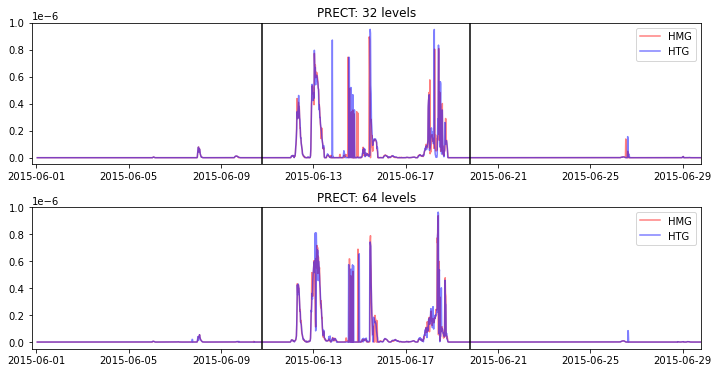

In [154]:
fig, axs_all = plt.subplots(2,1, figsize=(12, 6),
                     facecolor='w', edgecolor='k')
axs = axs_all.ravel()
fig.subplots_adjust(hspace=0.3)

# Plot 32 levels:
# ---------------
axs[0].plot(timesHTG_32local, np.squeeze(hmgDS_32.PRECT.values)[:],'r', label='HMG',alpha=0.5)
axs[0].plot(timesHTG_32local, np.squeeze(htgDS_32.PRECT.values)[:],'b', label='HTG',alpha=0.5)
axs[0].legend()
axs[0].set_title('PRECT: 32 levels')
axs[0].set_xlim(datetime.date(2015,6,1),datetime.date(2015,6,30))
#axs[0].set_xlim(datetime.date(2015,6,11),datetime.date(2015,6,20))
axs[0].set_ylim([-0.05e-6, 1e-6])
axs[0].axvline(datetime.datetime(2015,6,20),color='k')
axs[0].axvline(datetime.datetime(2015,6,11),color='k')

# Plot 64 levels:
# ---------------
axs[1].plot(timesHTG_64local, np.squeeze(hmgDS_64.PRECT.values)[:],'r', label='HMG',alpha=0.5)
axs[1].plot(timesHTG_64local, np.squeeze(htgDS_64.PRECT.values)[:],'b', label='HTG',alpha=0.5)
axs[1].legend()
axs[1].set_title('PRECT: 64 levels')
axs[1].set_xlim(datetime.date(2015,6,1),datetime.date(2015,6,30))
axs[1].axvline(datetime.datetime(2015,6,20),color='k')
axs[1].axvline(datetime.datetime(2015,6,11),color='k')
#axs[1].set_xlim(datetime.date(2015,6,11),datetime.date(2015,6,20))
axs[1].set_ylim([-0.05e-6, 1e-6])


In [143]:
# Print out total precipitation from each simulation/vertical resolution
print('Total June precipitation [m/s]')
print('              HMG       HTG')
print('32levs: %10.2e %10.2e ' % (np.nansum(hmgDS_32.PRECT.values), np.nansum(htgDS_32.PRECT.values)))
print('64levs: %10.2e %10.2e ' % (np.nansum(hmgDS_64.PRECT.values), np.nansum(htgDS_64.PRECT.values)))


Total June precipitation [m/s]
              HMG       HTG
32levs:   4.80e-05   4.77e-05 
64levs:   4.65e-05   4.73e-05 


In [155]:
# Define three different periods... 
iEarlyDry = np.where(timesHTG_64local.day<=11)[0]
iWet      = np.where( (timesHTG_64local.day>=12) & (timesHTG_64local.day<=19) )[0]
iLateDry  = np.where(timesHTG_64local.day>=20)[0]

# Define early dry periods... 
hmg32_earlyDry = hmgDS_32.isel(time=iEarlyDry)
htg32_earlyDry = htgDS_32.isel(time=iEarlyDry)
hmg64_earlyDry = hmgDS_64.isel(time=iEarlyDry)
htg64_earlyDry = htgDS_64.isel(time=iEarlyDry)

# Define wet period...
hmg32_wet = hmgDS_32.isel(time=iWet)
htg32_wet = htgDS_32.isel(time=iWet)
hmg64_wet = hmgDS_64.isel(time=iWet)
htg64_wet = htgDS_64.isel(time=iWet)

# Define late dry periods...
hmg32_lateDry = hmgDS_32.isel(time=iLateDry)
htg32_lateDry = htgDS_32.isel(time=iLateDry)
hmg64_lateDry = hmgDS_64.isel(time=iLateDry)
htg64_lateDry = htgDS_64.isel(time=iLateDry)


**What does the average diurnal cycle of PBLH look like in these cases/periods?**

In [162]:
# -------------------------------- 
#   Early dry period 
# -------------------------------- 

# Mean diurnal cycle (in UTC time, though)
meanDiurnal_earlyDry_htg32 = htg32_earlyDry.groupby("time.hour").mean()
meanDiurnal_earlyDry_hmg32 = hmg32_earlyDry.groupby("time.hour").mean()

meanDiurnal_earlyDry_htg64 = htg64_earlyDry.groupby("time.hour").mean()
meanDiurnal_earlyDry_hmg64 = hmg64_earlyDry.groupby("time.hour").mean()

# Easier to plot in local time, so let's double up on the diurnal cycle,
#  Then plot the correct section representing 12a-12a
# 
# CDT to UTC: 12a CDT = 6a UTC, so 6 hour offset 
htg_diurnalPBL32_double       = np.full([48], np.nan)
htg_diurnalPBL32_double[0:24] = np.squeeze(meanDiurnal_earlyDry_htg32.PBLH.values)
htg_diurnalPBL32_double[24::] = np.squeeze(meanDiurnal_earlyDry_htg32.PBLH.values)
htg32_diurnalPBLH_earlyDry    = htg_diurnalPBL32_double[6:30]

hmg_diurnalPBL32_double       = np.full([48], np.nan)
hmg_diurnalPBL32_double[0:24] = np.squeeze(meanDiurnal_earlyDry_hmg32.PBLH.values)
hmg_diurnalPBL32_double[24::] = np.squeeze(meanDiurnal_earlyDry_hmg32.PBLH.values)
hmg32_diurnalPBLH_earlyDry    = hmg_diurnalPBL32_double[6:30]

htg_diurnalPBL64_double       = np.full([48], np.nan)
htg_diurnalPBL64_double[0:24] = np.squeeze(meanDiurnal_earlyDry_htg64.PBLH.values)
htg_diurnalPBL64_double[24::] = np.squeeze(meanDiurnal_earlyDry_htg64.PBLH.values)
htg64_diurnalPBLH_earlyDry    = htg_diurnalPBL64_double[6:30]

hmg_diurnalPBL64_double       = np.full([48], np.nan)
hmg_diurnalPBL64_double[0:24] = np.squeeze(meanDiurnal_earlyDry_hmg64.PBLH.values)
hmg_diurnalPBL64_double[24::] = np.squeeze(meanDiurnal_earlyDry_hmg64.PBLH.values)
hmg64_diurnalPBLH_earlyDry    = hmg_diurnalPBL64_double[6:30]



In [165]:
# -------------------------------- 
#   Wet period 
# -------------------------------- 

# Mean diurnal cycle (in UTC time, though)
meanDiurnal_wet_htg32 = htg32_wet.groupby("time.hour").mean()
meanDiurnal_wet_hmg32 = hmg32_wet.groupby("time.hour").mean()

meanDiurnal_wet_htg64 = htg64_wet.groupby("time.hour").mean()
meanDiurnal_wet_hmg64 = hmg64_wet.groupby("time.hour").mean()

# Easier to plot in local time, so let's double up on the diurnal cycle,
#  Then plot the correct section representing 12a-12a
# 
# CDT to UTC: 12a CDT = 6a UTC, so 6 hour offset 
htg_diurnalPBL32_double       = np.full([48], np.nan)
htg_diurnalPBL32_double[0:24] = np.squeeze(meanDiurnal_wet_htg32.PBLH.values)
htg_diurnalPBL32_double[24::] = np.squeeze(meanDiurnal_wet_htg32.PBLH.values)
htg32_diurnalPBLH_wet         = htg_diurnalPBL32_double[6:30]

hmg_diurnalPBL32_double       = np.full([48], np.nan)
hmg_diurnalPBL32_double[0:24] = np.squeeze(meanDiurnal_wet_hmg32.PBLH.values)
hmg_diurnalPBL32_double[24::] = np.squeeze(meanDiurnal_wet_hmg32.PBLH.values)
hmg32_diurnalPBLH_wet         = hmg_diurnalPBL32_double[6:30]

htg_diurnalPBL64_double       = np.full([48], np.nan)
htg_diurnalPBL64_double[0:24] = np.squeeze(meanDiurnal_wet_htg64.PBLH.values)
htg_diurnalPBL64_double[24::] = np.squeeze(meanDiurnal_wet_htg64.PBLH.values)
htg64_diurnalPBLH_wet         = htg_diurnalPBL64_double[6:30]

hmg_diurnalPBL64_double       = np.full([48], np.nan)
hmg_diurnalPBL64_double[0:24] = np.squeeze(meanDiurnal_wet_hmg64.PBLH.values)
hmg_diurnalPBL64_double[24::] = np.squeeze(meanDiurnal_wet_hmg64.PBLH.values)
hmg64_diurnalPBLH_wet         = hmg_diurnalPBL64_double[6:30]


In [167]:
# -------------------------------- 
#   Late dry period 
# -------------------------------- 

# Mean diurnal cycle (in UTC time, though)
meanDiurnal_lateDry_htg32 = htg32_lateDry.groupby("time.hour").mean()
meanDiurnal_lateDry_hmg32 = hmg32_lateDry.groupby("time.hour").mean()

meanDiurnal_lateDry_htg64 = htg64_lateDry.groupby("time.hour").mean()
meanDiurnal_lateDry_hmg64 = hmg64_lateDry.groupby("time.hour").mean()

# Easier to plot in local time, so let's double up on the diurnal cycle,
#  Then plot the correct section representing 12a-12a
# 
# CDT to UTC: 12a CDT = 6a UTC, so 6 hour offset 
htg_diurnalPBL32_double       = np.full([48], np.nan)
htg_diurnalPBL32_double[0:24] = np.squeeze(meanDiurnal_lateDry_htg32.PBLH.values)
htg_diurnalPBL32_double[24::] = np.squeeze(meanDiurnal_lateDry_htg32.PBLH.values)
htg32_diurnalPBLH_lateDry     = htg_diurnalPBL32_double[6:30]

hmg_diurnalPBL32_double       = np.full([48], np.nan)
hmg_diurnalPBL32_double[0:24] = np.squeeze(meanDiurnal_lateDry_hmg32.PBLH.values)
hmg_diurnalPBL32_double[24::] = np.squeeze(meanDiurnal_lateDry_hmg32.PBLH.values)
hmg32_diurnalPBLH_lateDry     = hmg_diurnalPBL32_double[6:30]

htg_diurnalPBL64_double       = np.full([48], np.nan)
htg_diurnalPBL64_double[0:24] = np.squeeze(meanDiurnal_lateDry_htg64.PBLH.values)
htg_diurnalPBL64_double[24::] = np.squeeze(meanDiurnal_lateDry_htg64.PBLH.values)
htg64_diurnalPBLH_lateDry     = htg_diurnalPBL64_double[6:30]

hmg_diurnalPBL64_double       = np.full([48], np.nan)
hmg_diurnalPBL64_double[0:24] = np.squeeze(meanDiurnal_lateDry_hmg64.PBLH.values)
hmg_diurnalPBL64_double[24::] = np.squeeze(meanDiurnal_lateDry_hmg64.PBLH.values)
hmg64_diurnalPBLH_lateDry     = hmg_diurnalPBL64_double[6:30]




Text(0.5, 0, 'Hour (local)')

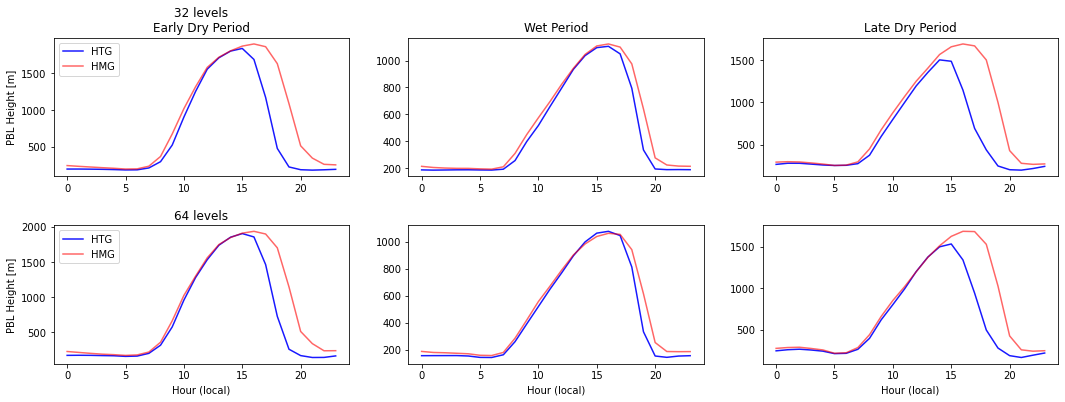

In [178]:
# What is the differenct in PBLH within each of these? 
fig, axs_all = plt.subplots(2,3, figsize=(18, 6),
                     facecolor='w', edgecolor='k')
axs = axs_all.ravel()
fig.subplots_adjust(hspace=0.35)

# ------------
#  32 levels 
# ------------

axs[0].plot(meanDiurnal_HTG32.hour.values,htg32_diurnalPBLH_earlyDry,'b',label='HTG',alpha=0.9)
axs[0].plot(meanDiurnal_HTG32.hour.values,hmg32_diurnalPBLH_earlyDry,'r',label='HMG',alpha=0.6)
axs[0].set_title('32 levels\nEarly Dry Period')
axs[0].legend(loc='upper left')
axs[0].set_ylabel('PBL Height [m]')

axs[1].plot(meanDiurnal_HTG32.hour.values,htg32_diurnalPBLH_wet,'b',label='HTG',alpha=0.9)
axs[1].plot(meanDiurnal_HTG32.hour.values,hmg32_diurnalPBLH_wet,'r',label='HMG',alpha=0.6)
axs[1].set_title('Wet Period')

axs[2].plot(meanDiurnal_HTG32.hour.values,htg32_diurnalPBLH_lateDry,'b',label='HTG',alpha=0.9)
axs[2].plot(meanDiurnal_HTG32.hour.values,hmg32_diurnalPBLH_lateDry,'r',label='HMG',alpha=0.6)
axs[2].set_title('Late Dry Period')


# ------------
#  64 levels 
# ------------

axs[3].plot(meanDiurnal_HTG32.hour.values,htg64_diurnalPBLH_earlyDry,'b',label='HTG',alpha=0.9)
axs[3].plot(meanDiurnal_HTG32.hour.values,hmg64_diurnalPBLH_earlyDry,'r',label='HMG',alpha=0.6)
axs[3].set_title('64 levels')
axs[3].legend(loc='upper left')
axs[3].set_ylabel('PBL Height [m]')
axs[3].set_xlabel('Hour (local)')

axs[4].plot(meanDiurnal_HTG32.hour.values,htg64_diurnalPBLH_wet,'b',label='HTG',alpha=0.9)
axs[4].plot(meanDiurnal_HTG32.hour.values,hmg64_diurnalPBLH_wet,'r',label='HMG',alpha=0.6)
axs[4].set_xlabel('Hour (local)')

axs[5].plot(meanDiurnal_HTG32.hour.values,htg64_diurnalPBLH_lateDry,'b',label='HTG',alpha=0.9)
axs[5].plot(meanDiurnal_HTG32.hour.values,hmg64_diurnalPBLH_lateDry,'r',label='HMG',alpha=0.6)
axs[5].set_xlabel('Hour (local)')


**Composites over these periods to look at vertical evolution of fields**

Specific Humidity

In [226]:
# Get mean over days...? 
np.shape(Q_hmg32[iEarlyDry,:,:,:])

# hrsLocal = np.arange(0,24)
# minLocal = np.asarray([0,20,40])

# nTimes   = len(hrsLocal)*len(minLocal)

dailyQ_hmg32 = np.full([30,72, len(pnew32)], np.nan)
dailyQ_htg32 = np.full([30,72, len(pnew32)], np.nan)
dailyQ_hmg64 = np.full([30,72, len(pnew64)], np.nan)
dailyQ_htg64 = np.full([30,72, len(pnew64)], np.nan)

for days in range(29):
    iDay = np.where(timesHMG_32local.day==(days+1))[0]
    
    # The first day starts at 01 local time, not 00, so missing 3 first points:
    if days==0:
        dailyQ_hmg32[days,3::,:] = np.squeeze(Q_hmg32)[iDay,:]
        dailyQ_htg32[days,3::,:] = np.squeeze(Q_htg32)[iDay,:]
        
        dailyQ_hmg64[days,3::,:] = np.squeeze(Q_hmg64)[iDay,:]
        dailyQ_htg64[days,3::,:] = np.squeeze(Q_htg64)[iDay,:]
    else:
        dailyQ_hmg32[days,:,:]   = np.squeeze(Q_hmg32)[iDay,:]
        dailyQ_htg32[days,:,:]   = np.squeeze(Q_htg32)[iDay,:]
        
        dailyQ_hmg64[days,:,:]   = np.squeeze(Q_hmg64)[iDay,:]
        dailyQ_htg64[days,:,:]   = np.squeeze(Q_htg64)[iDay,:]
        
# Average over all the days in a period 
# earlyPeriod_Qhmg32 = np.nanmean(dailyQ_hmg32[0:11,:,:], axis=0)
# earlyPeriod_Qhtg32 = np.nanmean(dailyQ_htg32[0:11,:,:], axis=0)
# earlyPeriod_Qhmg64 = np.nanmean(dailyQ_hmg64[0:11,:,:], axis=0)
# earlyPeriod_Qhtg64 = np.nanmean(dailyQ_htg64[0:11,:,:], axis=0)
earlyPeriod_Qdiff32  = np.nanmean( (dailyQ_htg32[0:11,:,:] - dailyQ_hmg32[0:11,:,:]), axis=0)
earlyPeriod_Qdiff64  = np.nanmean( (dailyQ_htg64[0:11,:,:] - dailyQ_hmg64[0:11,:,:]), axis=0)

# wetPeriod_Qhmg32 = np.nanmean(dailyQ_hmg32[11:20,:,:], axis=0)
# wetPeriod_Qhtg32 = np.nanmean(dailyQ_htg32[11:20,:,:], axis=0)
# wetPeriod_Qhmg64 = np.nanmean(dailyQ_hmg64[11:20,:,:], axis=0)
# wetPeriod_Qhtg64 = np.nanmean(dailyQ_htg64[11:20,:,:], axis=0)
wetPeriod_Qdiff32  = np.nanmean( (dailyQ_htg32[11:20,:,:] - dailyQ_hmg32[11:20,:,:]), axis=0)
wetPeriod_Qdiff64  = np.nanmean( (dailyQ_htg64[11:20,:,:] - dailyQ_hmg64[11:20,:,:]), axis=0)

# latePeriod_Qhmg32 = np.nanmean(dailyQ_hmg32[20::,:,:], axis=0)
# latePeriod_Qhtg32 = np.nanmean(dailyQ_htg32[20::,:,:], axis=0)
# latePeriod_Qhmg64 = np.nanmean(dailyQ_hmg64[20::,:,:], axis=0)
# latePeriod_Qhtg64 = np.nanmean(dailyQ_htg64[20::,:,:], axis=0)
latePeriod_Qdiff32  = np.nanmean( (dailyQ_htg32[20::,:,:] - dailyQ_hmg32[20::,:,:]), axis=0)
latePeriod_Qdiff64  = np.nanmean( (dailyQ_htg64[20::,:,:] - dailyQ_hmg64[20::,:,:]), axis=0)


In [225]:
np.shape(earlyPeriod_Qhmg32)

(72, 12)

In [212]:
# iDay = np.where(timesHMG_32local.day==1)[0]
# len(timesHMG_32local[iDay])
# timesHMG_32local[iDay]


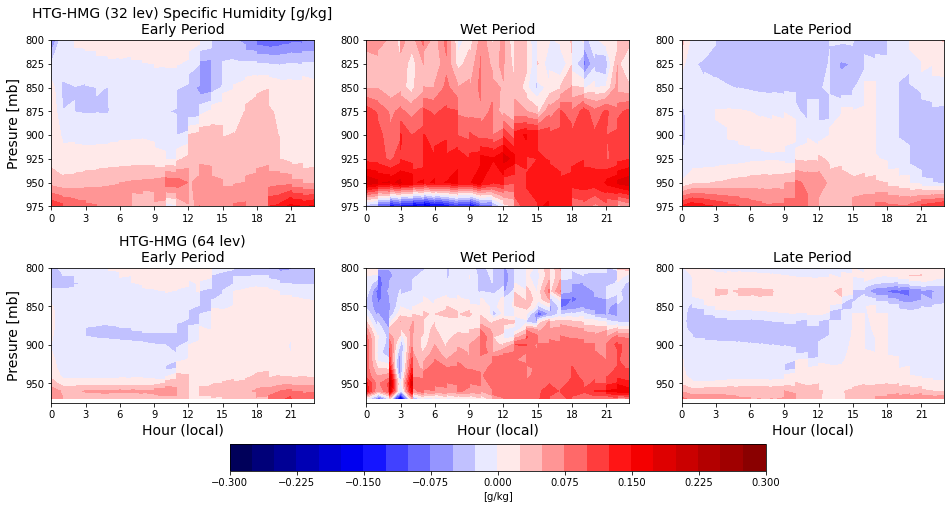

In [242]:
fig, axs_all = plt.subplots(2,3, figsize=(16, 8),
                     facecolor='w', edgecolor='k')
axs = axs_all.ravel()
fig.subplots_adjust(hspace=0.1)

#Tlevs = np.arange(0.0020,0.01,0.0005)
Qlevs = np.arange(3.0,11.0,0.5)
Qdiff_levs = np.arange(-0.3,0.325,0.025)

cmap = axs[0].contourf(timesHMG_32local[timeSel].hour,pnew32, np.transpose(earlyPeriod_Qdiff32*1000.0), 
                       Qdiff_levs,
                       cmap='seismic')
axs[0].set_ylim([800,975])
axs[0].xaxis.set_major_locator(plt.MaxNLocator(8))
axs[0].set_ylabel('Presure [mb]',fontsize=14)
axs[0].set_title('HTG-HMG (32 lev) Specific Humidity [g/kg]\nEarly Period', fontsize=14)
axs[0].invert_yaxis()

cmap = axs[1].contourf(timesHMG_32local[timeSel].hour,pnew32, np.transpose(wetPeriod_Qdiff32*1000.0), 
                       Qdiff_levs,
                       cmap='seismic')
axs[1].set_ylim([800,975])
axs[1].xaxis.set_major_locator(plt.MaxNLocator(8))
axs[1].set_title('\nWet Period', fontsize=14)
axs[1].invert_yaxis()

cmap = axs[2].contourf(timesHMG_32local[timeSel].hour,pnew32, np.transpose(latePeriod_Qdiff32*1000.0), 
                       Qdiff_levs,
                       cmap='seismic')
axs[2].set_ylim([800,975])
axs[2].xaxis.set_major_locator(plt.MaxNLocator(8))
axs[2].set_title('\nLate Period', fontsize=14)
axs[2].invert_yaxis()

# Since no colorbar here, want to shrink top row too...
divider2 = make_axes_locatable(axs[0])
cax2 = divider2.append_axes("bottom", size="3%", pad=0.5)
cax2.axis('off')
divider2 = make_axes_locatable(axs[1])
cax2 = divider2.append_axes("bottom", size="3%", pad=0.5)
cax2.axis('off')
divider2 = make_axes_locatable(axs[2])
cax2 = divider2.append_axes("bottom", size="3%", pad=0.5)
cax2.axis('off')


# ------------------------ 
# Plot 64 levels too
# ------------------------
cmap = axs[3].contourf(timesHMG_32local[timeSel].hour,pnew64, np.transpose(earlyPeriod_Qdiff64*1000.0), 
                       Qdiff_levs,
                       cmap='seismic')
axs[3].set_ylim([800,975])

axs[3].xaxis.set_major_locator(plt.MaxNLocator(8))
axs[3].set_xlabel('Hour (local)',fontsize=14)
axs[3].set_ylabel('Presure [mb]',fontsize=14)
axs[3].set_title('HTG-HMG (64 lev)\nEarly Period', fontsize=14)
axs[3].invert_yaxis()

cmap = axs[4].contourf(timesHMG_32local[timeSel].hour,pnew64, np.transpose(wetPeriod_Qdiff64*1000.0), 
                       Qdiff_levs,
                       cmap='seismic')
axs[4].set_ylim([800,975])
axs[4].xaxis.set_major_locator(plt.MaxNLocator(8))
axs[4].set_xlabel('Hour (local)',fontsize=14)
axs[4].set_title('\nWet Period', fontsize=14)
axs[4].invert_yaxis()

fig.colorbar(cmap,ax=axs_all[1,:],orientation='horizontal',pad=0.2,shrink=0.6,label='[g/kg]')


cmap = axs[5].contourf(timesHMG_32local[timeSel].hour,pnew64, np.transpose(latePeriod_Qdiff64*1000.0), 
                       Qdiff_levs,
                       cmap='seismic')
axs[5].set_ylim([800,975])
axs[5].xaxis.set_major_locator(plt.MaxNLocator(8))
axs[5].set_xlabel('Hour (local)',fontsize=14)
axs[5].set_title('\nLate Period', fontsize=14)
axs[5].invert_yaxis()


Text(0.5, 1.0, '8-10a Mean Specific Humidity [HTG-HMG]\nLate Period')

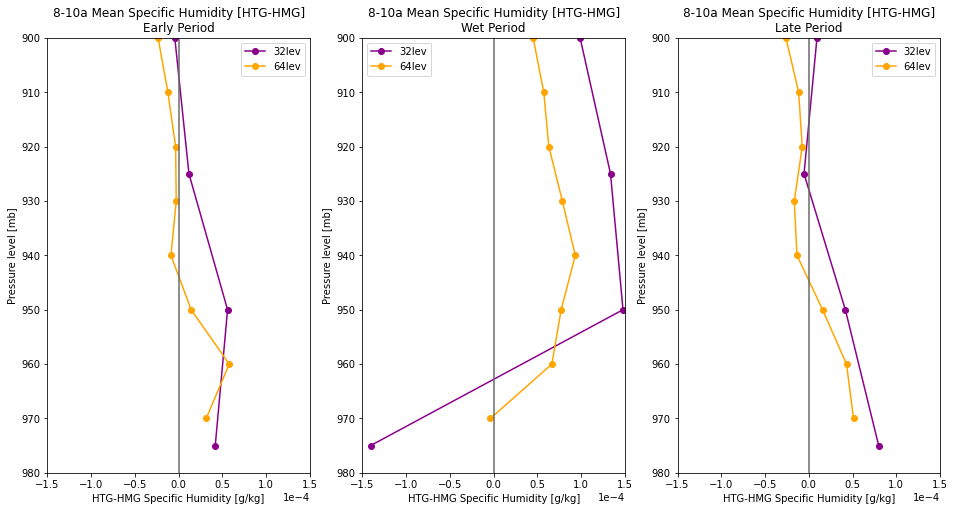

In [276]:
# Plot mean vertical profiles in morning? (8-10a local)
iMorning     = np.where((timesHMG_32local[timeSel].hour>=8) & (timesHMG_32local[timeSel].hour<10))[0]

fig, axs_all = plt.subplots(1,3, figsize=(16, 8),
                     facecolor='w', edgecolor='k')
axs = axs_all.ravel()
fig.subplots_adjust(hspace=0.1)


axs[0].plot(np.nanmean(earlyPeriod_Qdiff32[iMorning,:], axis=0), pnew32,'o-',color='darkmagenta',label='32lev')
axs[0].plot(np.nanmean(earlyPeriod_Qdiff64[iMorning,:], axis=0), pnew64,'o-',color='orange',label='64lev')
axs[0].axvline(0,color='dimgrey')
axs[0].set_ylim([900,980])
axs[0].invert_yaxis()
axs[0].legend()
axs[0].set_xlim([-15e-5,15e-5])
axs[0].ticklabel_format(axis='x',style='sci',scilimits=(0,0))
axs[0].set_ylabel('Pressure level [mb]')
axs[0].set_xlabel('HTG-HMG Specific Humidity [g/kg]')
axs[0].set_title('8-10a Mean Specific Humidity [HTG-HMG]\nEarly Period')

axs[1].plot(np.nanmean(wetPeriod_Qdiff32[iMorning,:], axis=0), pnew32,'o-',color='darkmagenta',label='32lev')
axs[1].plot(np.nanmean(wetPeriod_Qdiff64[iMorning,:], axis=0), pnew64,'o-',color='orange',label='64lev')
axs[1].axvline(0,color='dimgrey')
axs[1].set_ylim([900,980])
axs[1].invert_yaxis()
axs[1].legend()
axs[1].set_xlim([-15e-5,15e-5])
axs[1].ticklabel_format(axis='x',style='sci',scilimits=(0,0))
axs[1].set_ylabel('Pressure level [mb]')
axs[1].set_xlabel('HTG-HMG Specific Humidity [g/kg]')
axs[1].set_title('8-10a Mean Specific Humidity [HTG-HMG]\nWet Period')

axs[2].plot(np.nanmean(latePeriod_Qdiff32[iMorning,:], axis=0), pnew32,'o-',color='darkmagenta',label='32lev')
axs[2].plot(np.nanmean(latePeriod_Qdiff64[iMorning,:], axis=0), pnew64,'o-',color='orange',label='64lev')
axs[2].axvline(0,color='dimgrey')
axs[2].set_ylim([900,980])
axs[2].invert_yaxis()
axs[2].legend()
axs[2].set_xlim([-15e-5,15e-5])
axs[2].ticklabel_format(axis='x',style='sci',scilimits=(0,0))
axs[2].set_ylabel('Pressure level [mb]')
axs[2].set_xlabel('HTG-HMG Specific Humidity [g/kg]')
axs[2].set_title('8-10a Mean Specific Humidity [HTG-HMG]\nLate Period')


## Comparison over a single day [06/04/2015], which we've used as a case study

In [49]:
timeSel     = np.where((timesHMG_32local.day==4))[0]

hmgDS_32sel = hmgDS_32.isel(time=timeSel)
htgDS_32sel = htgDS_32.isel(time=timeSel)
noMom_sel   = noMomDS.isel(time=timeSel)
hmgDS_64sel = hmgDS_64.isel(time=timeSel)
htgDS_64sel = htgDS_64.isel(time=timeSel)



In [50]:
np.shape(Q_hmg32)

(2088, 12, 1, 1)

(6.0, 18.0)

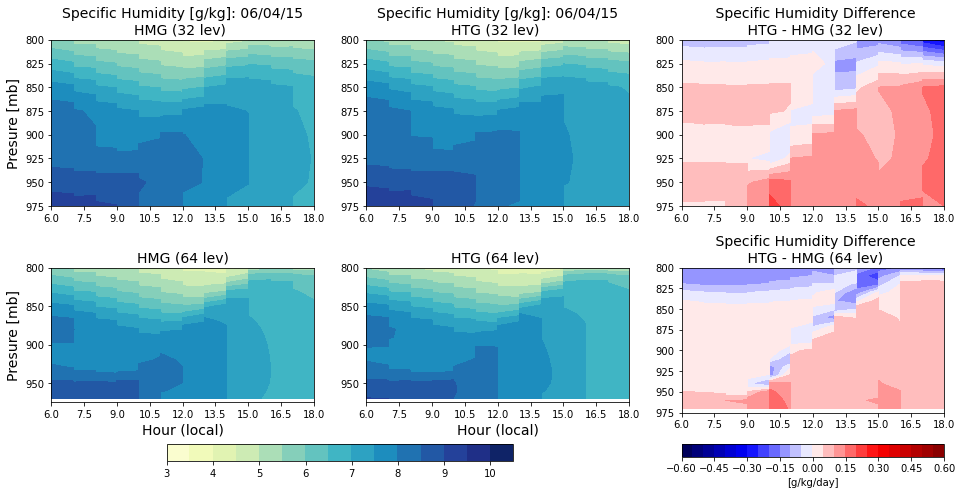

In [54]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig, axs_all = plt.subplots(2,3, figsize=(16, 8),
                     facecolor='w', edgecolor='k')
axs = axs_all.ravel()
fig.subplots_adjust(hspace=0.1)

#Tlevs = np.arange(0.0020,0.01,0.0005)
Qlevs = np.arange(3.0,11.0,0.5)
Qdiff_levs = np.arange(-0.6,0.65,0.05)

cmap = axs[0].contourf(timesHMG_32local[timeSel].hour,pnew32, np.transpose(np.squeeze(Q_hmg32[timeSel,:,:,:])*1000.0), Qlevs,
                      cmap='YlGnBu')
axs[0].set_ylim([800,975])
axs[0].xaxis.set_major_locator(plt.MaxNLocator(8))
axs[0].set_ylabel('Presure [mb]',fontsize=14)
axs[0].set_title('Specific Humidity [g/kg]: 06/04/15\nHMG (32 lev) ', fontsize=14)
axs[0].invert_yaxis()

cmap = axs[1].contourf(timesHMG_32local[timeSel].hour,pnew32, np.transpose(np.squeeze(Q_htg32[timeSel,:,:,:])*1000.0), Qlevs,
                      cmap='YlGnBu')
axs[1].set_ylim([800,975])
axs[1].xaxis.set_major_locator(plt.MaxNLocator(8))
axs[1].set_title('Specific Humidity [g/kg]: 06/04/15\nHTG (32 lev) ', fontsize=14)
axs[1].invert_yaxis()

# Plot difference in third panel
diff_32 = ((np.squeeze(Q_htg32[timeSel,:,:,:])*1000.0) - (np.squeeze(Q_hmg32[timeSel,:,:,:])*1000.0))
cmap    = axs[2].contourf(timesHMG_32local[timeSel].hour,pnew32, np.transpose(diff_32), Qdiff_levs,
                      cmap='seismic')
axs[2].set_ylim([800,975])
axs[2].xaxis.set_major_locator(plt.MaxNLocator(8))
axs[2].set_title(' Specific Humidity Difference\n HTG - HMG (32 lev)', fontsize=14)
axs[2].invert_yaxis()


# Since no colorbar here, want to shrink top row too...
divider2 = make_axes_locatable(axs[0])
cax2 = divider2.append_axes("bottom", size="3%", pad=0.5)
cax2.axis('off')
divider2 = make_axes_locatable(axs[1])
cax2 = divider2.append_axes("bottom", size="3%", pad=0.5)
cax2.axis('off')
divider2 = make_axes_locatable(axs[2])
cax2 = divider2.append_axes("bottom", size="3%", pad=0.5)
cax2.axis('off')


# ------------------------ 
# Plot 64 levels too
# ------------------------
cmap = axs[3].contourf(timesHMG_32local[timeSel].hour,pnew64, np.transpose(np.squeeze(Q_hmg64[timeSel,:,:,:])*1000.0), Qlevs,
                       cmap='YlGnBu')
axs[3].set_ylim([800,975])

axs[3].xaxis.set_major_locator(plt.MaxNLocator(8))
axs[3].set_xlabel('Hour (local)',fontsize=14)
axs[3].set_ylabel('Presure [mb]',fontsize=14)
axs[3].set_title('HMG (64 lev)', fontsize=14)
axs[3].invert_yaxis()

fig.colorbar(cmap,ax=axs_all[1,0:2],orientation='horizontal',pad=0.2,shrink=0.6,)

cmap = axs[4].contourf(timesHMG_32local[timeSel].hour,pnew64, np.transpose(np.squeeze(Q_htg64[timeSel,:,:,:])*1000.0), Qlevs,
                      cmap='YlGnBu')
axs[4].set_ylim([800,975])
axs[4].xaxis.set_major_locator(plt.MaxNLocator(8))
axs[4].set_xlabel('Hour (local)',fontsize=14)
axs[4].set_title('HTG (64 lev) ', fontsize=14)
axs[4].invert_yaxis()

# Plot difference in third panel
diff_128 = ((np.squeeze(Q_htg64[timeSel,:,:,:])*1000.0) - (np.squeeze(Q_hmg64[timeSel,:,:,:])*1000.0))
cmap    = axs[5].contourf(timesHMG_32local[timeSel].hour,pnew64, np.transpose(diff_128), Qdiff_levs,
                      cmap='seismic')
axs[5].set_ylim([800,975])
axs[5].xaxis.set_major_locator(plt.MaxNLocator(8))
axs[5].set_title(' Specific Humidity Difference\n HTG - HMG (64 lev)', fontsize=14)
axs[5].invert_yaxis()
fig.colorbar(cmap,ax=axs_all[1,2],orientation='horizontal',label = '[g/kg/day]')


# Limit x axis?
axs[0].set_xlim([6,18])
axs[1].set_xlim([6,18])
axs[2].set_xlim([6,18])
axs[3].set_xlim([6,18])
axs[4].set_xlim([6,18])
axs[5].set_xlim([6,18])




(6.0, 18.0)

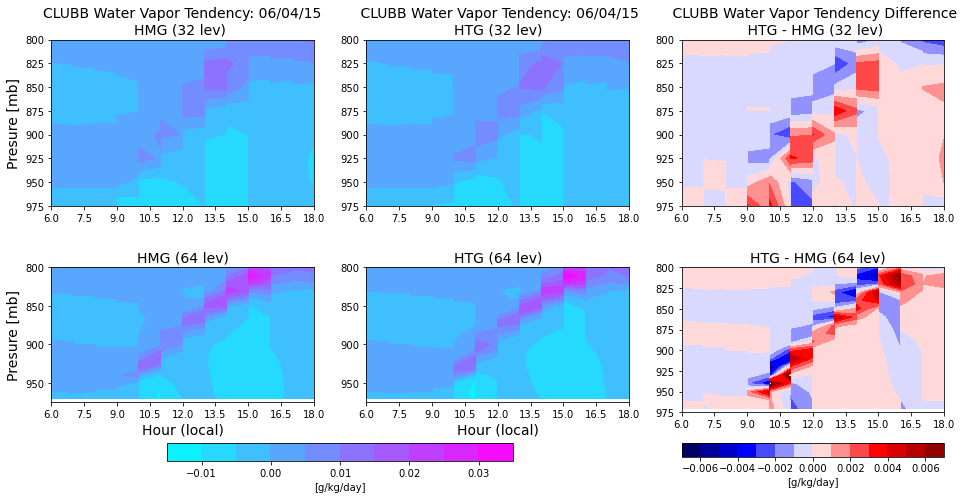

In [56]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig, axs_all = plt.subplots(2,3, figsize=(16, 8), 
                     facecolor='w', edgecolor='k')
axs = axs_all.ravel()
fig.subplots_adjust(hspace=0.1)

#Tlevs = np.arange(0.0020,0.01,0.0005)
#Qlevs = np.arange(3.0,11.0,0.5)
#RVMlevs = np.arange(-5,35,5)
RVMlevs      = np.arange(-0.015,0.04,0.005)
RVMdiff_levs = np.arange(-0.007,0.0075,0.001)

cmap = axs[0].contourf(timesHMG_32local[timeSel].hour,pnew32, 
                       np.transpose(np.squeeze(RVMTEND_hmg32[timeSel,:,:,:])*86400.0), 
                       RVMlevs,
                       cmap='cool')
axs[0].set_ylim([800,975])
axs[0].xaxis.set_major_locator(plt.MaxNLocator(8))
axs[0].set_ylabel('Presure [mb]',fontsize=14)
axs[0].set_title('CLUBB Water Vapor Tendency: 06/04/15\nHMG (32 lev) ', fontsize=14)
axs[0].invert_yaxis()

#fig.colorbar(cmap,ax=axs_all[:],orientation='horizontal',shrink=0.4)
# Since no colorbar here, want to shrink top row too...
divider2 = make_axes_locatable(axs[0])
cax2 = divider2.append_axes("bottom", size="3%", pad=0.5)
cax2.axis('off')
divider2 = make_axes_locatable(axs[1])
cax2 = divider2.append_axes("bottom", size="3%", pad=0.5)
cax2.axis('off')
divider2 = make_axes_locatable(axs[2])
cax2 = divider2.append_axes("bottom", size="3%", pad=0.5)
cax2.axis('off')

cmap = axs[1].contourf(timesHMG_32local[timeSel].hour,pnew32, 
                       np.transpose(np.squeeze(RVMTEND_htg32[timeSel,:,:,:])*86400.0), 
                       RVMlevs,
                       cmap='cool')
axs[1].set_ylim([800,975])
axs[1].xaxis.set_major_locator(plt.MaxNLocator(8))
axs[1].set_title(' CLUBB Water Vapor Tendency: 06/04/15\nHTG (32 lev)', fontsize=14)
axs[1].invert_yaxis()

# Plot difference in third panel...
diff_32    = ((np.squeeze(RVMTEND_htg32[timeSel,:,:,:])*86400.0) - (np.squeeze(RVMTEND_hmg32[timeSel,:,:,:])*86400.0))

cmap    = axs[2].contourf(timesHMG_32local[timeSel].hour,pnew32, 
                          np.transpose(diff_32), 
                          RVMdiff_levs,
                          cmap='seismic')
axs[2].set_ylim([800,975])
axs[2].xaxis.set_major_locator(plt.MaxNLocator(8))
axs[2].set_title(' CLUBB Water Vapor Tendency Difference\n HTG - HMG (32 lev)', fontsize=14)
axs[2].invert_yaxis()
# fig.colorbar(cmap,ax=axs_all[0,2],orientation='horizontal',label = '[g/kg/day]')


# ------------------------ 
# Plot 64 levels too
# ------------------------
cmap = axs[3].contourf(timesHMG_32local[timeSel].hour,pnew64, 
                       np.transpose(np.squeeze(RVMTEND_hmg64[timeSel,:,:,:])*86400.0), 
                       RVMlevs,
                       cmap='cool')
axs[3].set_ylim([800,975])
axs[3].xaxis.set_major_locator(plt.MaxNLocator(8))
axs[3].set_xlabel('Hour (local)',fontsize=14)
axs[3].set_ylabel('Presure [mb]',fontsize=14)
axs[3].set_title('HMG (64 lev)', fontsize=14)
axs[3].invert_yaxis()

# Add colorbar 
fig.colorbar(cmap,ax=axs_all[1,0:2],orientation='horizontal',pad=0.2,shrink=0.6,label='[g/kg/day]')

cmap = axs[4].contourf(timesHMG_32local[timeSel].hour,pnew64, 
                       np.transpose(np.squeeze(RVMTEND_htg64[timeSel,:,:,:])*86400.0), 
                       RVMlevs,
                       cmap='cool')
axs[4].set_ylim([800,975])
axs[4].xaxis.set_major_locator(plt.MaxNLocator(8))
axs[4].set_xlabel('Hour (local)',fontsize=14)
axs[4].set_title('HTG (64 lev)', fontsize=14)
axs[4].invert_yaxis
axs[4].invert_yaxis()

# Plot difference in third panel...
diff_64    = ((np.squeeze(RVMTEND_htg64[timeSel,:,:,:])*86400.0) - (np.squeeze(RVMTEND_hmg64[timeSel,:,:,:])*86400.0))

cmap    = axs[5].contourf(timesHMG_32local[timeSel].hour,pnew64, 
                          np.transpose(diff_64), 
                          RVMdiff_levs,
                          cmap='seismic')
axs[5].set_ylim([800,975])
axs[5].xaxis.set_major_locator(plt.MaxNLocator(8))
axs[5].set_title('  HTG - HMG (64 lev)', fontsize=14)
axs[5].invert_yaxis()
fig.colorbar(cmap,ax=axs_all[1,2],orientation='horizontal',label = '[g/kg/day]')

# Limit x axis?
axs[0].set_xlim([6,18])
axs[1].set_xlim([6,18])
axs[2].set_xlim([6,18])
axs[3].set_xlim([6,18])
axs[4].set_xlim([6,18])
axs[5].set_xlim([6,18])



(6.0, 18.0)

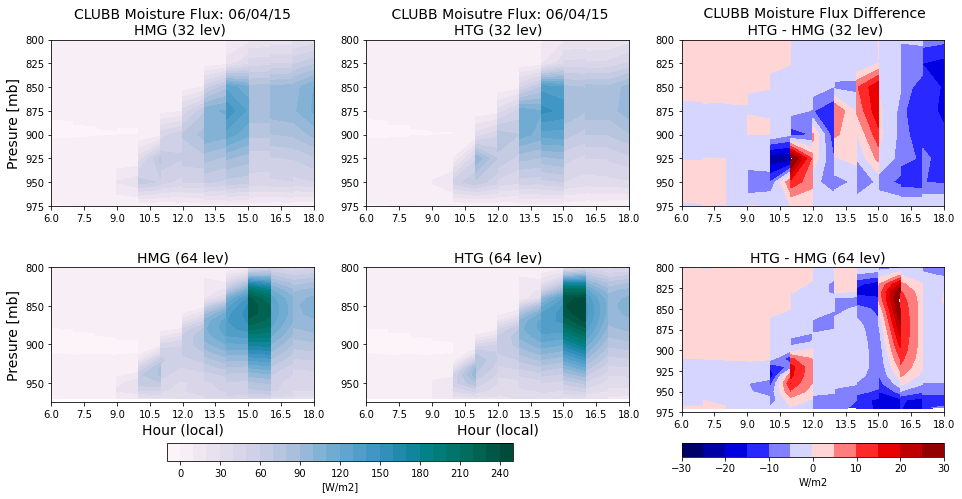

In [63]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig, axs_all = plt.subplots(2,3, figsize=(16, 8), 
                     facecolor='w', edgecolor='k')
axs = axs_all.ravel()
fig.subplots_adjust(hspace=0.1)

WPRTPlevs      = np.arange(-10,260,10)
#WPRTPlevs      = 20
WPRTPdiff_levs = np.arange(-30,35,5)
#WPRTPdiff_levs = 20

cmap = axs[0].contourf(timesHMG_32local[timeSel].hour,pnew32, 
                       np.transpose(np.squeeze(WPRTP_hmg32[timeSel,:,:,:])), 
                       WPRTPlevs,
                       cmap='PuBuGn')
axs[0].set_ylim([800,975])
axs[0].xaxis.set_major_locator(plt.MaxNLocator(8))
axs[0].set_ylabel('Presure [mb]',fontsize=14)
axs[0].set_title('CLUBB Moisture Flux: 06/04/15\nHMG (32 lev) ', fontsize=14)
axs[0].invert_yaxis()

#fig.colorbar(cmap,ax=axs_all[:],orientation='horizontal',shrink=0.4)
# Since no colorbar here, want to shrink top row too...
divider2 = make_axes_locatable(axs[0])
cax2 = divider2.append_axes("bottom", size="3%", pad=0.5)
cax2.axis('off')
divider2 = make_axes_locatable(axs[1])
cax2 = divider2.append_axes("bottom", size="3%", pad=0.5)
cax2.axis('off')
divider2 = make_axes_locatable(axs[2])
cax2 = divider2.append_axes("bottom", size="3%", pad=0.5)
cax2.axis('off')

cmap = axs[1].contourf(timesHMG_32local[timeSel].hour,pnew32, 
                       np.transpose(np.squeeze(WPRTP_htg32[timeSel,:,:,:])), 
                       WPRTPlevs,
                       cmap='PuBuGn')
axs[1].set_ylim([800,975])
axs[1].xaxis.set_major_locator(plt.MaxNLocator(8))
axs[1].set_title(' CLUBB Moisutre Flux: 06/04/15\nHTG (32 lev)', fontsize=14)
axs[1].invert_yaxis()

# Plot difference in third panel...
diff_32    = ((np.squeeze(WPRTP_htg32[timeSel,:,:,:])) - (np.squeeze(WPRTP_hmg32[timeSel,:,:,:])))

cmap    = axs[2].contourf(timesHMG_32local[timeSel].hour,pnew32, 
                          np.transpose(diff_32), 
                          WPRTPdiff_levs,
                          cmap='seismic')
axs[2].set_ylim([800,975])
axs[2].xaxis.set_major_locator(plt.MaxNLocator(8))
axs[2].set_title(' CLUBB Moisture Flux Difference\n HTG - HMG (32 lev)', fontsize=14)
axs[2].invert_yaxis()
# fig.colorbar(cmap,ax=axs_all[0,2],orientation='horizontal',label = '[g/kg/day]')


# ------------------------ 
# Plot 64 levels too
# ------------------------
cmap = axs[3].contourf(timesHMG_32local[timeSel].hour,pnew64, 
                       np.transpose(np.squeeze(WPRTP_hmg64[timeSel,:,:,:])), 
                       WPRTPlevs,
                       cmap='PuBuGn')
axs[3].set_ylim([800,975])
axs[3].xaxis.set_major_locator(plt.MaxNLocator(8))
axs[3].set_xlabel('Hour (local)',fontsize=14)
axs[3].set_ylabel('Presure [mb]',fontsize=14)
axs[3].set_title('HMG (64 lev)', fontsize=14)
axs[3].invert_yaxis()

# Add colorbar 
fig.colorbar(cmap,ax=axs_all[1,0:2],orientation='horizontal',pad=0.2,shrink=0.6,label='[W/m2]')

cmap = axs[4].contourf(timesHMG_32local[timeSel].hour,pnew64, 
                       np.transpose(np.squeeze(WPRTP_htg64[timeSel,:,:,:])), 
                       WPRTPlevs,
                       cmap='PuBuGn')
axs[4].set_ylim([800,975])
axs[4].xaxis.set_major_locator(plt.MaxNLocator(8))
axs[4].set_xlabel('Hour (local)',fontsize=14)
axs[4].set_title('HTG (64 lev)', fontsize=14)
axs[4].invert_yaxis
axs[4].invert_yaxis()

# Plot difference in third panel...
diff_64 = ((np.squeeze(WPRTP_htg64[timeSel,:,:,:])) - (np.squeeze(WPRTP_hmg64[timeSel,:,:,:])))

cmap    = axs[5].contourf(timesHMG_32local[timeSel].hour,pnew64, np.transpose(diff_64), 
                          WPRTPdiff_levs,
                          cmap='seismic')
axs[5].set_ylim([800,975])
axs[5].xaxis.set_major_locator(plt.MaxNLocator(8))
axs[5].set_title('  HTG - HMG (64 lev)', fontsize=14)
axs[5].invert_yaxis()
fig.colorbar(cmap,ax=axs_all[1,2],orientation='horizontal',label = 'W/m2')

# Limit x axis?
axs[0].set_xlim([6,18])
axs[1].set_xlim([6,18])
axs[2].set_xlim([6,18])
axs[3].set_xlim([6,18])
axs[4].set_xlim([6,18])
axs[5].set_xlim([6,18])



(6.0, 18.0)

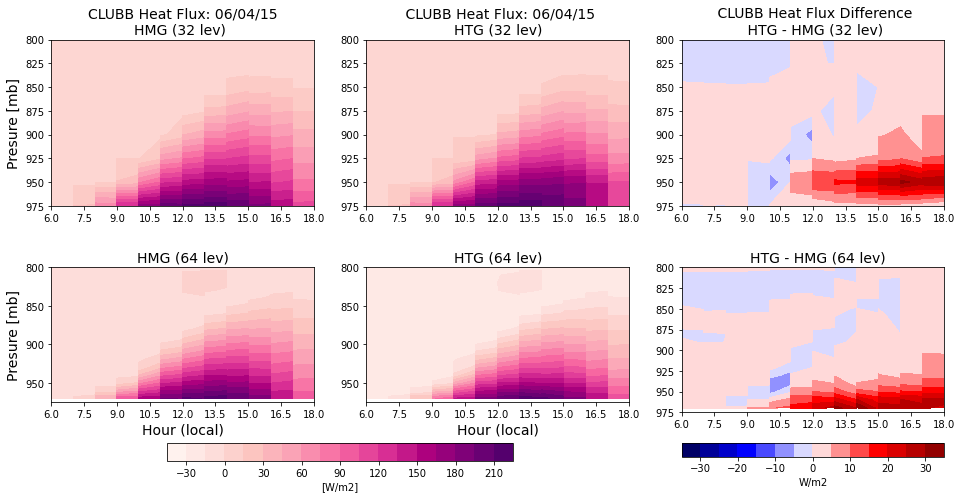

In [67]:
fig, axs_all = plt.subplots(2,3, figsize=(16, 8), 
                     facecolor='w', edgecolor='k')
axs = axs_all.ravel()
fig.subplots_adjust(hspace=0.1)

WWPTHLPlevs  = np.arange(-30,230,30)
#WPTHLPlevs      = 20
WPTHLPdiff_levs = np.arange(-35,40,5)
#WPTHLPdiff_levs = 20

cmap = axs[0].contourf(timesHMG_32local[timeSel].hour,pnew32, 
                       np.transpose(np.squeeze(WPTHLP_hmg32[timeSel,:,:,:])), 
                       WPTHLPlevs,
                       cmap='RdPu')
axs[0].set_ylim([800,975])
axs[0].xaxis.set_major_locator(plt.MaxNLocator(8))
axs[0].set_ylabel('Presure [mb]',fontsize=14)
axs[0].set_title('CLUBB Heat Flux: 06/04/15\nHMG (32 lev) ', fontsize=14)
axs[0].invert_yaxis()

#fig.colorbar(cmap,ax=axs_all[:],orientation='horizontal',shrink=0.4)
# Since no colorbar here, want to shrink top row too...
divider2 = make_axes_locatable(axs[0])
cax2 = divider2.append_axes("bottom", size="3%", pad=0.5)
cax2.axis('off')
divider2 = make_axes_locatable(axs[1])
cax2 = divider2.append_axes("bottom", size="3%", pad=0.5)
cax2.axis('off')
divider2 = make_axes_locatable(axs[2])
cax2 = divider2.append_axes("bottom", size="3%", pad=0.5)
cax2.axis('off')

cmap = axs[1].contourf(timesHMG_32local[timeSel].hour,pnew32, 
                       np.transpose(np.squeeze(WPTHLP_htg32[timeSel,:,:,:])), 
                       WPTHLPlevs,
                       cmap='RdPu')
axs[1].set_ylim([800,975])
axs[1].xaxis.set_major_locator(plt.MaxNLocator(8))
axs[1].set_title(' CLUBB Heat Flux: 06/04/15\nHTG (32 lev)', fontsize=14)
axs[1].invert_yaxis()

# Plot difference in third panel...
diff_32    = ((np.squeeze(WPTHLP_htg32[timeSel,:,:,:])) - (np.squeeze(WPTHLP_hmg32[timeSel,:,:,:])))

cmap    = axs[2].contourf(timesHMG_32local[timeSel].hour,pnew32, 
                          np.transpose(diff_32), 
                          WPTHLPdiff_levs,
                          cmap='seismic')
axs[2].set_ylim([800,975])
axs[2].xaxis.set_major_locator(plt.MaxNLocator(8))
axs[2].set_title(' CLUBB Heat Flux Difference\n HTG - HMG (32 lev)', fontsize=14)
axs[2].invert_yaxis()
# fig.colorbar(cmap,ax=axs_all[0,2],orientation='horizontal',label = '[g/kg/day]')


# ------------------------ 
# Plot 64 levels too
# ------------------------
cmap = axs[3].contourf(timesHMG_32local[timeSel].hour,pnew64, 
                       np.transpose(np.squeeze(WPTHLP_hmg64[timeSel,:,:,:])), 
                       WPTHLPlevs,
                       cmap='RdPu')
axs[3].set_ylim([800,975])
axs[3].xaxis.set_major_locator(plt.MaxNLocator(8))
axs[3].set_xlabel('Hour (local)',fontsize=14)
axs[3].set_ylabel('Presure [mb]',fontsize=14)
axs[3].set_title('HMG (64 lev)', fontsize=14)
axs[3].invert_yaxis()

# Add colorbar 
fig.colorbar(cmap,ax=axs_all[1,0:2],orientation='horizontal',pad=0.2,shrink=0.6,label='[W/m2]')

cmap = axs[4].contourf(timesHMG_32local[timeSel].hour,pnew64, 
                       np.transpose(np.squeeze(WPTHLP_htg64[timeSel,:,:,:])), 
                       WPTHLPlevs,
                       cmap='RdPu')
axs[4].set_ylim([800,975])
axs[4].xaxis.set_major_locator(plt.MaxNLocator(8))
axs[4].set_xlabel('Hour (local)',fontsize=14)
axs[4].set_title('HTG (64 lev)', fontsize=14)
axs[4].invert_yaxis
axs[4].invert_yaxis()

# Plot difference in third panel...
diff_64 = ((np.squeeze(WPTHLP_htg64[timeSel,:,:,:])) - (np.squeeze(WPTHLP_hmg64[timeSel,:,:,:])))

cmap    = axs[5].contourf(timesHMG_32local[timeSel].hour,pnew64, np.transpose(diff_64), 
                          WPTHLPdiff_levs,
                          cmap='seismic')
axs[5].set_ylim([800,975])
axs[5].xaxis.set_major_locator(plt.MaxNLocator(8))
axs[5].set_title('  HTG - HMG (64 lev)', fontsize=14)
axs[5].invert_yaxis()
fig.colorbar(cmap,ax=axs_all[1,2],orientation='horizontal',label = 'W/m2')

# Limit x axis?
axs[0].set_xlim([6,18])
axs[1].set_xlim([6,18])
axs[2].set_xlim([6,18])
axs[3].set_xlim([6,18])
axs[4].set_xlim([6,18])
axs[5].set_xlim([6,18])




(6.0, 18.0)

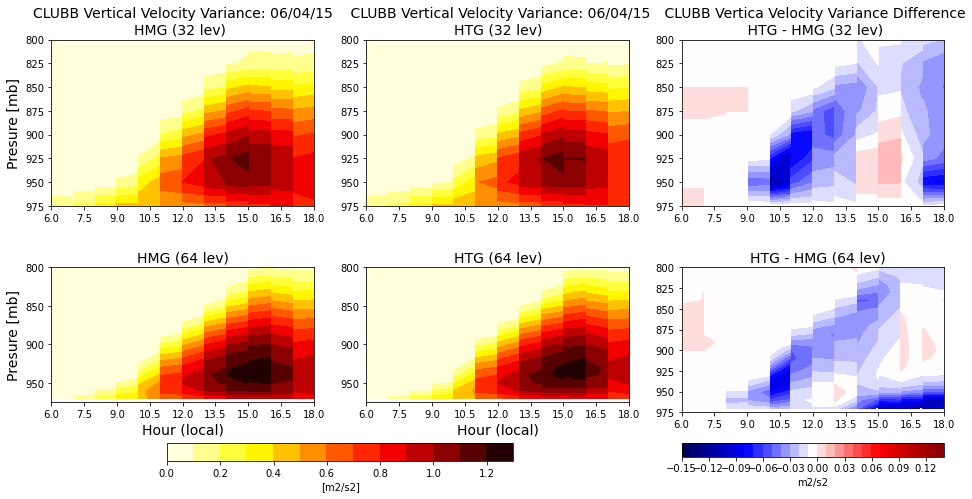

In [71]:
fig, axs_all = plt.subplots(2,3, figsize=(16, 8), 
                     facecolor='w', edgecolor='k')
axs = axs_all.ravel()
fig.subplots_adjust(hspace=0.1)

WP2levs  = np.arange(0,1.4,0.1)
#WP2levs      = 20
WP2diff_levs = np.arange(-.15,0.15,0.01)
#WP2diff_levs = 20

cmap = axs[0].contourf(timesHMG_32local[timeSel].hour,pnew32, 
                       np.transpose(np.squeeze(WP2_hmg32[timeSel,:,:,:])), 
                       WP2levs,
                       cmap='hot_r')
axs[0].set_ylim([800,975])
axs[0].xaxis.set_major_locator(plt.MaxNLocator(8))
axs[0].set_ylabel('Presure [mb]',fontsize=14)
axs[0].set_title('CLUBB Vertical Velocity Variance: 06/04/15\nHMG (32 lev) ', fontsize=14)
axs[0].invert_yaxis()

#fig.colorbar(cmap,ax=axs_all[:],orientation='horizontal',shrink=0.4)
# Since no colorbar here, want to shrink top row too...
divider2 = make_axes_locatable(axs[0])
cax2 = divider2.append_axes("bottom", size="3%", pad=0.5)
cax2.axis('off')
divider2 = make_axes_locatable(axs[1])
cax2 = divider2.append_axes("bottom", size="3%", pad=0.5)
cax2.axis('off')
divider2 = make_axes_locatable(axs[2])
cax2 = divider2.append_axes("bottom", size="3%", pad=0.5)
cax2.axis('off')

cmap = axs[1].contourf(timesHMG_32local[timeSel].hour,pnew32, 
                       np.transpose(np.squeeze(WP2_htg32[timeSel,:,:,:])), 
                       WP2levs,
                       cmap='hot_r')
axs[1].set_ylim([800,975])
axs[1].xaxis.set_major_locator(plt.MaxNLocator(8))
axs[1].set_title(' CLUBB Vertical Velocity Variance: 06/04/15\nHTG (32 lev)', fontsize=14)
axs[1].invert_yaxis()

# Plot difference in third panel...
diff_32    = ((np.squeeze(WP2_htg32[timeSel,:,:,:])) - (np.squeeze(WP2_hmg32[timeSel,:,:,:])))

cmap    = axs[2].contourf(timesHMG_32local[timeSel].hour,pnew32, 
                          np.transpose(diff_32), 
                          WP2diff_levs,
                          cmap='seismic')
axs[2].set_ylim([800,975])
axs[2].xaxis.set_major_locator(plt.MaxNLocator(8))
axs[2].set_title(' CLUBB Vertica Velocity Variance Difference\n HTG - HMG (32 lev)', fontsize=14)
axs[2].invert_yaxis()
# fig.colorbar(cmap,ax=axs_all[0,2],orientation='horizontal',label = '[g/kg/day]')


# ------------------------ 
# Plot 64 levels too
# ------------------------
cmap = axs[3].contourf(timesHMG_32local[timeSel].hour,pnew64, 
                       np.transpose(np.squeeze(WP2_hmg64[timeSel,:,:,:])), 
                       WP2levs,
                       cmap='hot_r')
axs[3].set_ylim([800,975])
axs[3].xaxis.set_major_locator(plt.MaxNLocator(8))
axs[3].set_xlabel('Hour (local)',fontsize=14)
axs[3].set_ylabel('Presure [mb]',fontsize=14)
axs[3].set_title('HMG (64 lev)', fontsize=14)
axs[3].invert_yaxis()

# Add colorbar 
fig.colorbar(cmap,ax=axs_all[1,0:2],orientation='horizontal',pad=0.2,shrink=0.6,label='[m2/s2]')

cmap = axs[4].contourf(timesHMG_32local[timeSel].hour,pnew64, 
                       np.transpose(np.squeeze(WP2_htg64[timeSel,:,:,:])), 
                       WP2levs,
                       cmap='hot_r')
axs[4].set_ylim([800,975])
axs[4].xaxis.set_major_locator(plt.MaxNLocator(8))
axs[4].set_xlabel('Hour (local)',fontsize=14)
axs[4].set_title('HTG (64 lev)', fontsize=14)
axs[4].invert_yaxis
axs[4].invert_yaxis()

# Plot difference in third panel...
diff_64 = ((np.squeeze(WP2_htg64[timeSel,:,:,:])) - (np.squeeze(WP2_hmg64[timeSel,:,:,:])))

cmap    = axs[5].contourf(timesHMG_32local[timeSel].hour,pnew64, np.transpose(diff_64), 
                          WP2diff_levs,
                          cmap='seismic')
axs[5].set_ylim([800,975])
axs[5].xaxis.set_major_locator(plt.MaxNLocator(8))
axs[5].set_title('  HTG - HMG (64 lev)', fontsize=14)
axs[5].invert_yaxis()
fig.colorbar(cmap,ax=axs_all[1,2],orientation='horizontal',label = 'm2/s2')

# Limit x axis?
axs[0].set_xlim([6,18])
axs[1].set_xlim([6,18])
axs[2].set_xlim([6,18])
axs[3].set_xlim([6,18])
axs[4].set_xlim([6,18])
axs[5].set_xlim([6,18])





(6.0, 18.0)

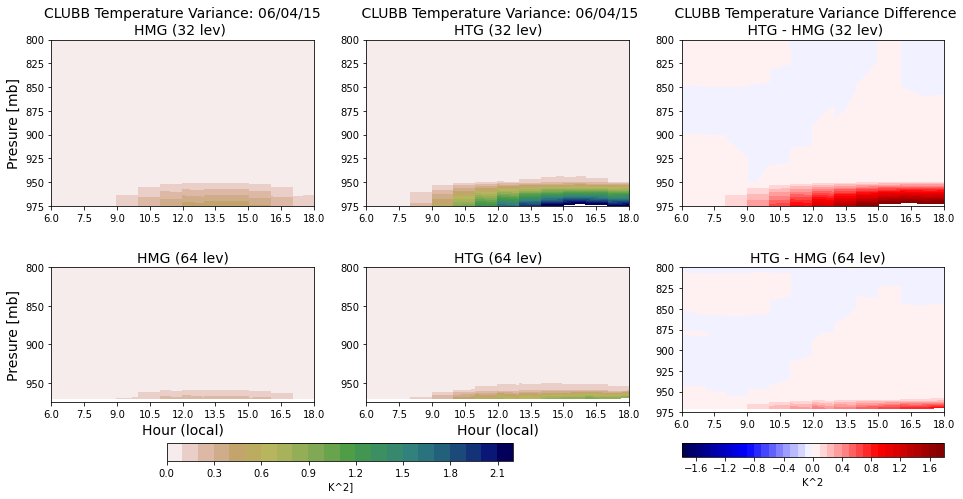

In [96]:
fig, axs_all = plt.subplots(2,3, figsize=(16, 8), 
                     facecolor='w', edgecolor='k')
axs = axs_all.ravel()
fig.subplots_adjust(hspace=0.1)

THLP2levs  = np.arange(0.0,2.3,0.1)
#THLP2levs      = 20
THLP2diff_levs = np.arange(-1.8,1.9,0.1)
#THLP2diff_levs = 20

cmap = axs[0].contourf(timesHMG_32local[timeSel].hour,pnew32, 
                       np.transpose(np.squeeze(THLP2_hmg32[timeSel,:,:,:])), 
                       THLP2levs,
                       cmap='gist_earth_r')
axs[0].set_ylim([800,975])
axs[0].xaxis.set_major_locator(plt.MaxNLocator(8))
axs[0].set_ylabel('Presure [mb]',fontsize=14)
axs[0].set_title('CLUBB Temperature Variance: 06/04/15\nHMG (32 lev) ', fontsize=14)
axs[0].invert_yaxis()

#fig.colorbar(cmap,ax=axs_all[:],orientation='horizontal',shrink=0.4)
# Since no colorbar here, want to shrink top row too...
divider2 = make_axes_locatable(axs[0])
cax2 = divider2.append_axes("bottom", size="3%", pad=0.5)
cax2.axis('off')
divider2 = make_axes_locatable(axs[1])
cax2 = divider2.append_axes("bottom", size="3%", pad=0.5)
cax2.axis('off')
divider2 = make_axes_locatable(axs[2])
cax2 = divider2.append_axes("bottom", size="3%", pad=0.5)
cax2.axis('off')

cmap = axs[1].contourf(timesHMG_32local[timeSel].hour,pnew32, 
                       np.transpose(np.squeeze(THLP2_htg32[timeSel,:,:,:])), 
                       THLP2levs,
                       cmap='gist_earth_r')
axs[1].set_ylim([800,975])
axs[1].xaxis.set_major_locator(plt.MaxNLocator(8))
axs[1].set_title(' CLUBB Temperature Variance: 06/04/15\nHTG (32 lev)', fontsize=14)
axs[1].invert_yaxis()

# Plot difference in third panel...
diff_32    = ((np.squeeze(THLP2_htg32[timeSel,:,:,:])) - (np.squeeze(THLP2_hmg32[timeSel,:,:,:])))

cmap    = axs[2].contourf(timesHMG_32local[timeSel].hour,pnew32, 
                          np.transpose(diff_32), 
                          THLP2diff_levs,
                          cmap='seismic')
axs[2].set_ylim([800,975])
axs[2].xaxis.set_major_locator(plt.MaxNLocator(8))
axs[2].set_title(' CLUBB Temperature Variance Difference\n HTG - HMG (32 lev)', fontsize=14)
axs[2].invert_yaxis()
# fig.colorbar(cmap,ax=axs_all[0,2],orientation='horizontal',label = '[g/kg/day]')


# ------------------------ 
# Plot 64 levels too
# ------------------------
cmap = axs[3].contourf(timesHMG_32local[timeSel].hour,pnew64, 
                       np.transpose(np.squeeze(THLP2_hmg64[timeSel,:,:,:])), 
                       THLP2levs,
                       cmap='gist_earth_r')
axs[3].set_ylim([800,975])
axs[3].xaxis.set_major_locator(plt.MaxNLocator(8))
axs[3].set_xlabel('Hour (local)',fontsize=14)
axs[3].set_ylabel('Presure [mb]',fontsize=14)
axs[3].set_title('HMG (64 lev)', fontsize=14)
axs[3].invert_yaxis()

# Add colorbar 
fig.colorbar(cmap,ax=axs_all[1,0:2],orientation='horizontal',pad=0.2,shrink=0.6,label='K^2]')

cmap = axs[4].contourf(timesHMG_32local[timeSel].hour,pnew64, 
                       np.transpose(np.squeeze(THLP2_htg64[timeSel,:,:,:])), 
                       THLP2levs,
                       cmap='gist_earth_r')
axs[4].set_ylim([800,975])
axs[4].xaxis.set_major_locator(plt.MaxNLocator(8))
axs[4].set_xlabel('Hour (local)',fontsize=14)
axs[4].set_title('HTG (64 lev)', fontsize=14)
axs[4].invert_yaxis
axs[4].invert_yaxis()

# Plot difference in third panel...
diff_64 = ((np.squeeze(THLP2_htg64[timeSel,:,:,:])) - (np.squeeze(THLP2_hmg64[timeSel,:,:,:])))

cmap    = axs[5].contourf(timesHMG_32local[timeSel].hour,pnew64, np.transpose(diff_64), 
                          THLP2diff_levs,
                          cmap='seismic')
axs[5].set_ylim([800,975])
axs[5].xaxis.set_major_locator(plt.MaxNLocator(8))
axs[5].set_title('  HTG - HMG (64 lev)', fontsize=14)
axs[5].invert_yaxis()
fig.colorbar(cmap,ax=axs_all[1,2],orientation='horizontal',label = 'K^2')

# Limit x axis?
axs[0].set_xlim([6,18])
axs[1].set_xlim([6,18])
axs[2].set_xlim([6,18])
axs[3].set_xlim([6,18])
axs[4].set_xlim([6,18])
axs[5].set_xlim([6,18])



(6.0, 18.0)

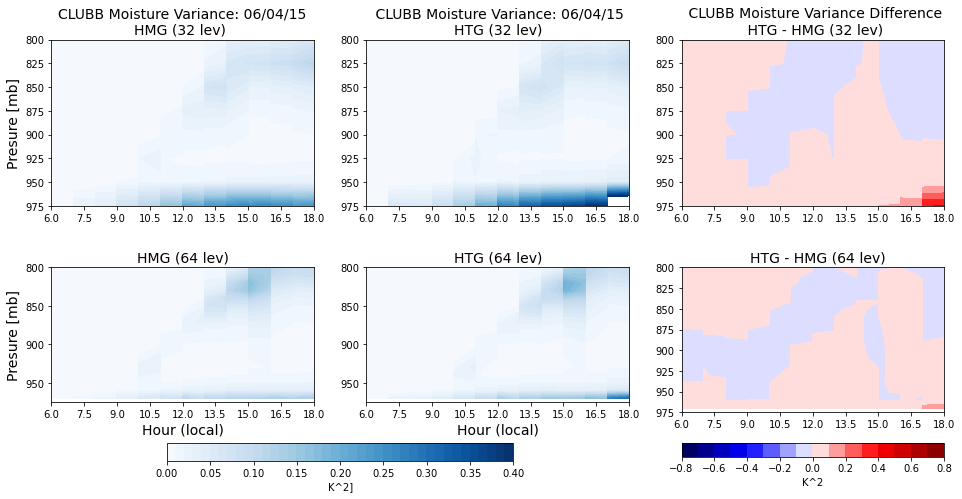

In [108]:
fig, axs_all = plt.subplots(2,3, figsize=(16, 8), 
                     facecolor='w', edgecolor='k')
axs = axs_all.ravel()
fig.subplots_adjust(hspace=0.1)

RTP2levs  = np.arange(0.0,0.41,0.01)
#RTP2levs      = 20
RTP2diff_levs = np.arange(-0.8,0.9,0.1)
#RTP2diff_levs = 20

cmap = axs[0].contourf(timesHMG_32local[timeSel].hour,pnew32, 
                       np.transpose(np.squeeze(RTP2_hmg32[timeSel,:,:,:])), 
                       RTP2levs,
                       cmap='Blues')
axs[0].set_ylim([800,975])
axs[0].xaxis.set_major_locator(plt.MaxNLocator(8))
axs[0].set_ylabel('Presure [mb]',fontsize=14)
axs[0].set_title('CLUBB Moisture Variance: 06/04/15\nHMG (32 lev) ', fontsize=14)
axs[0].invert_yaxis()

#fig.colorbar(cmap,ax=axs_all[:],orientation='horizontal',shrink=0.4)
# Since no colorbar here, want to shrink top row too...
divider2 = make_axes_locatable(axs[0])
cax2 = divider2.append_axes("bottom", size="3%", pad=0.5)
cax2.axis('off')
divider2 = make_axes_locatable(axs[1])
cax2 = divider2.append_axes("bottom", size="3%", pad=0.5)
cax2.axis('off')
divider2 = make_axes_locatable(axs[2])
cax2 = divider2.append_axes("bottom", size="3%", pad=0.5)
cax2.axis('off')

cmap = axs[1].contourf(timesHMG_32local[timeSel].hour,pnew32, 
                       np.transpose(np.squeeze(RTP2_htg32[timeSel,:,:,:])), 
                       RTP2levs,
                       cmap='Blues')
axs[1].set_ylim([800,975])
axs[1].xaxis.set_major_locator(plt.MaxNLocator(8))
axs[1].set_title(' CLUBB Moisture Variance: 06/04/15\nHTG (32 lev)', fontsize=14)
axs[1].invert_yaxis()

# Plot difference in third panel...
diff_32 = ((np.squeeze(RTP2_htg32[timeSel,:,:,:])) - (np.squeeze(RTP2_hmg32[timeSel,:,:,:])))

cmap    = axs[2].contourf(timesHMG_32local[timeSel].hour,pnew32, 
                          np.transpose(diff_32), 
                          RTP2diff_levs,
                          cmap='seismic')
axs[2].set_ylim([800,975])
axs[2].xaxis.set_major_locator(plt.MaxNLocator(8))
axs[2].set_title(' CLUBB Moisture Variance Difference\n HTG - HMG (32 lev)', fontsize=14)
axs[2].invert_yaxis()
# fig.colorbar(cmap,ax=axs_all[0,2],orientation='horizontal',label = '[g/kg/day]')


# ------------------------ 
# Plot 64 levels too
# ------------------------
cmap = axs[3].contourf(timesHMG_32local[timeSel].hour,pnew64, 
                       np.transpose(np.squeeze(RTP2_hmg64[timeSel,:,:,:])), 
                       RTP2levs,
                       cmap='Blues')
axs[3].set_ylim([800,975])
axs[3].xaxis.set_major_locator(plt.MaxNLocator(8))
axs[3].set_xlabel('Hour (local)',fontsize=14)
axs[3].set_ylabel('Presure [mb]',fontsize=14)
axs[3].set_title('HMG (64 lev)', fontsize=14)
axs[3].invert_yaxis()

# Add colorbar 
fig.colorbar(cmap,ax=axs_all[1,0:2],orientation='horizontal',pad=0.2,shrink=0.6,label='K^2]')

cmap = axs[4].contourf(timesHMG_32local[timeSel].hour,pnew64, 
                       np.transpose(np.squeeze(RTP2_htg64[timeSel,:,:,:])), 
                       RTP2levs,
                       cmap='Blues')
axs[4].set_ylim([800,975])
axs[4].xaxis.set_major_locator(plt.MaxNLocator(8))
axs[4].set_xlabel('Hour (local)',fontsize=14)
axs[4].set_title('HTG (64 lev)', fontsize=14)
axs[4].invert_yaxis
axs[4].invert_yaxis()

# Plot difference in third panel...
diff_64 = ((np.squeeze(RTP2_htg64[timeSel,:,:,:])) - (np.squeeze(RTP2_hmg64[timeSel,:,:,:])))

cmap    = axs[5].contourf(timesHMG_32local[timeSel].hour,pnew64, np.transpose(diff_64), 
                          RTP2diff_levs,
                          cmap='seismic')
axs[5].set_ylim([800,975])
axs[5].xaxis.set_major_locator(plt.MaxNLocator(8))
axs[5].set_title('  HTG - HMG (64 lev)', fontsize=14)
axs[5].invert_yaxis()
fig.colorbar(cmap,ax=axs_all[1,2],orientation='horizontal',label = 'K^2')

# Limit x axis?
axs[0].set_xlim([6,18])
axs[1].set_xlim([6,18])
axs[2].set_xlim([6,18])
axs[3].set_xlim([6,18])
axs[4].set_xlim([6,18])
axs[5].set_xlim([6,18])

